In [ ]:
import numpy
import pandas
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from operator import itemgetter
from matplotlib import pyplot
from matplotlib.patches import Ellipse
from yellowbrick.features import ParallelCoordinates
from yellowbrick.style.palettes import PALETTES
from scipy import linalg
from scipy.stats import chi2_contingency

In [ ]:
# Read in the dataset (replace with your actual file name)
f_data = " your_data_file_name.csv"
data = pandas.read_csv(f_data)
# Get the names of the linguistic complexity features from the column headers)
FT_nms = list(data.columns)[4:]
# Get the linguistic complexity feature matrix for later clustering
LC_data = data.to_numpy()[:, 4:]

# Standardize the data
LC_data_STD = scale(LC_data)

In [3]:
# Perform PCA on the standardized data
# Here we use the threshold of 60% cumulative variance, supported by empirical practices in L2 studies. You can change it based on your specific needs.
pca = PCA(n_components=0.6)
pca.fit(LC_data_STD)

# Get the number of PCs that altogether explain at least 60% variance
n_pc = len(pca.components_)

# Get the transposed loading matrix for easier interpretation 
# (rows = features, columns = PCs)
loadings = pandas.DataFrame(pca.components_.T, 
                        columns=["PC{}".format(i) 
                                 for i in range(1,n_pc+1)], 
                        index=FT_nms)

# Write the loading matrix to a CSV file
loadings.to_csv("PC_loadings.csv")

# Check the total variance explained by the resulted components
print("Total variance explained by the first {} components:".format(
    loadings.shape[1]), sum(pca.explained_variance_ratio_[:loadings.shape[1]]))

Total variance explained by the first 6 components: 0.6204656621270515


In [4]:
# Retain the four components, which are interpretable 
n_components = 4
# Check the total variance explained by the first n components
print("Total variance explained by the first {} components:".format(
    n_components), sum(pca.explained_variance_ratio_[:n_components]))
# Check the variance explained by each component
print("Variance explained by each component:", pca.explained_variance_ratio_[:n_components])

# Flip the sign of the first component to faciliate interpretation
pca.components_[0, :] = -pca.components_[0, :]
# Transform the data into PC scores
LC_data_trans = pca.transform(LC_data_STD)[:, :n_components]
# Write the transformed data to a CSV file
pandas.DataFrame(LC_data_trans, columns=["LexSoph", "LexDiv", "numpyComp", "CLComp"], 
             index=list(data["ID"])).to_csv("your_PC_data_file_name.csv")

Total variance explained by the first 4 components: 0.5192919170464838
Variance explained by each component: [0.25178545 0.12275486 0.07610578 0.06864583]


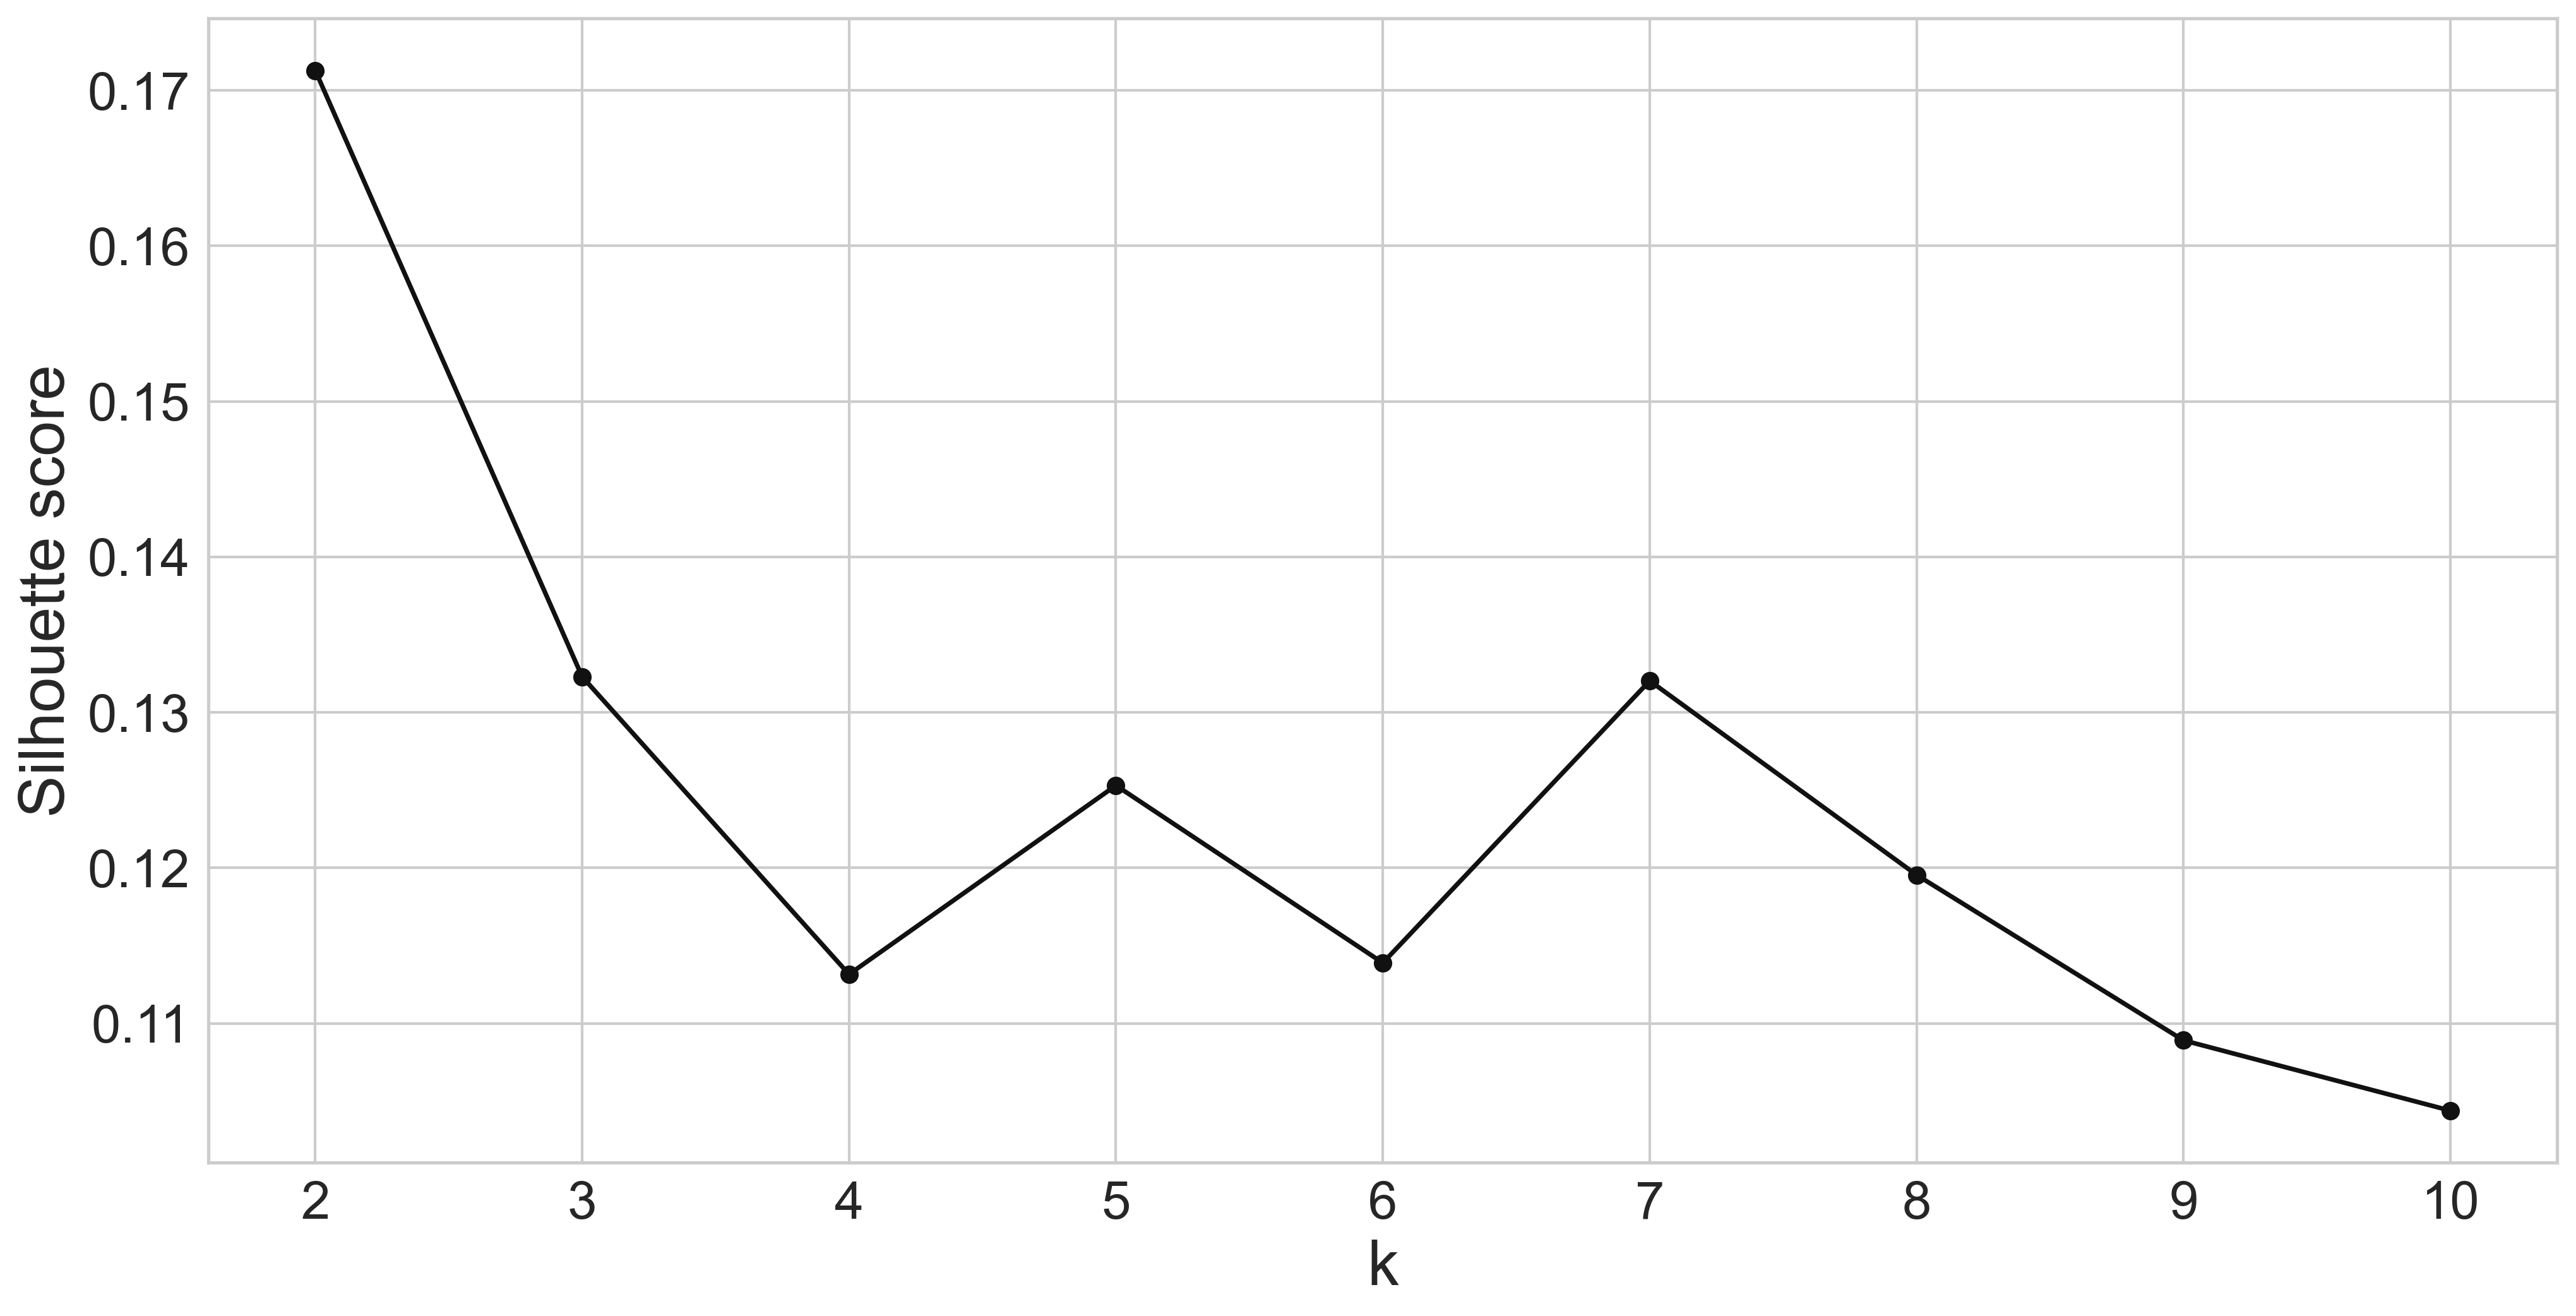

In [5]:
# Create empty list to store Silhouette scores for each k (number of clusters)
S=[]

# Range of number of clusters to compare (2 to 10)
K=range(2,11)

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=3, random_state=3)
    # Fit the model 
    labels = model.fit_predict(LC_data_trans)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(X=LC_data_trans, labels=labels, metric="mahalanobis"))

# Plot the resulting Silhouette scores on a graph
pyplot.figure(figsize=(16,8), dpi=300)
pyplot.plot(K, S, "ko-")
pyplot.xlabel("k", fontsize=24)
pyplot.ylabel("Silhouette score", fontsize=24)
pyplot.tick_params(axis="both", labelsize=20)
# Save the figure as a PDF
pyplot.savefig("silhouette_scores.pdf", format="pdf", bbox_inches="tight")
pyplot.show()

In [6]:
# Final model
# Specify the number of clusters
num_clusters=5
model = GaussianMixture(n_components=num_clusters, n_init=3, random_state=3)
labels = model.fit_predict(LC_data_trans)

# Add a new column to the original data to save the predicted labels
data["Cluster"] = labels
# Write the DataFrame to a CSV file
data.to_csv("your_clustered_data_file_name.csv", index=False)

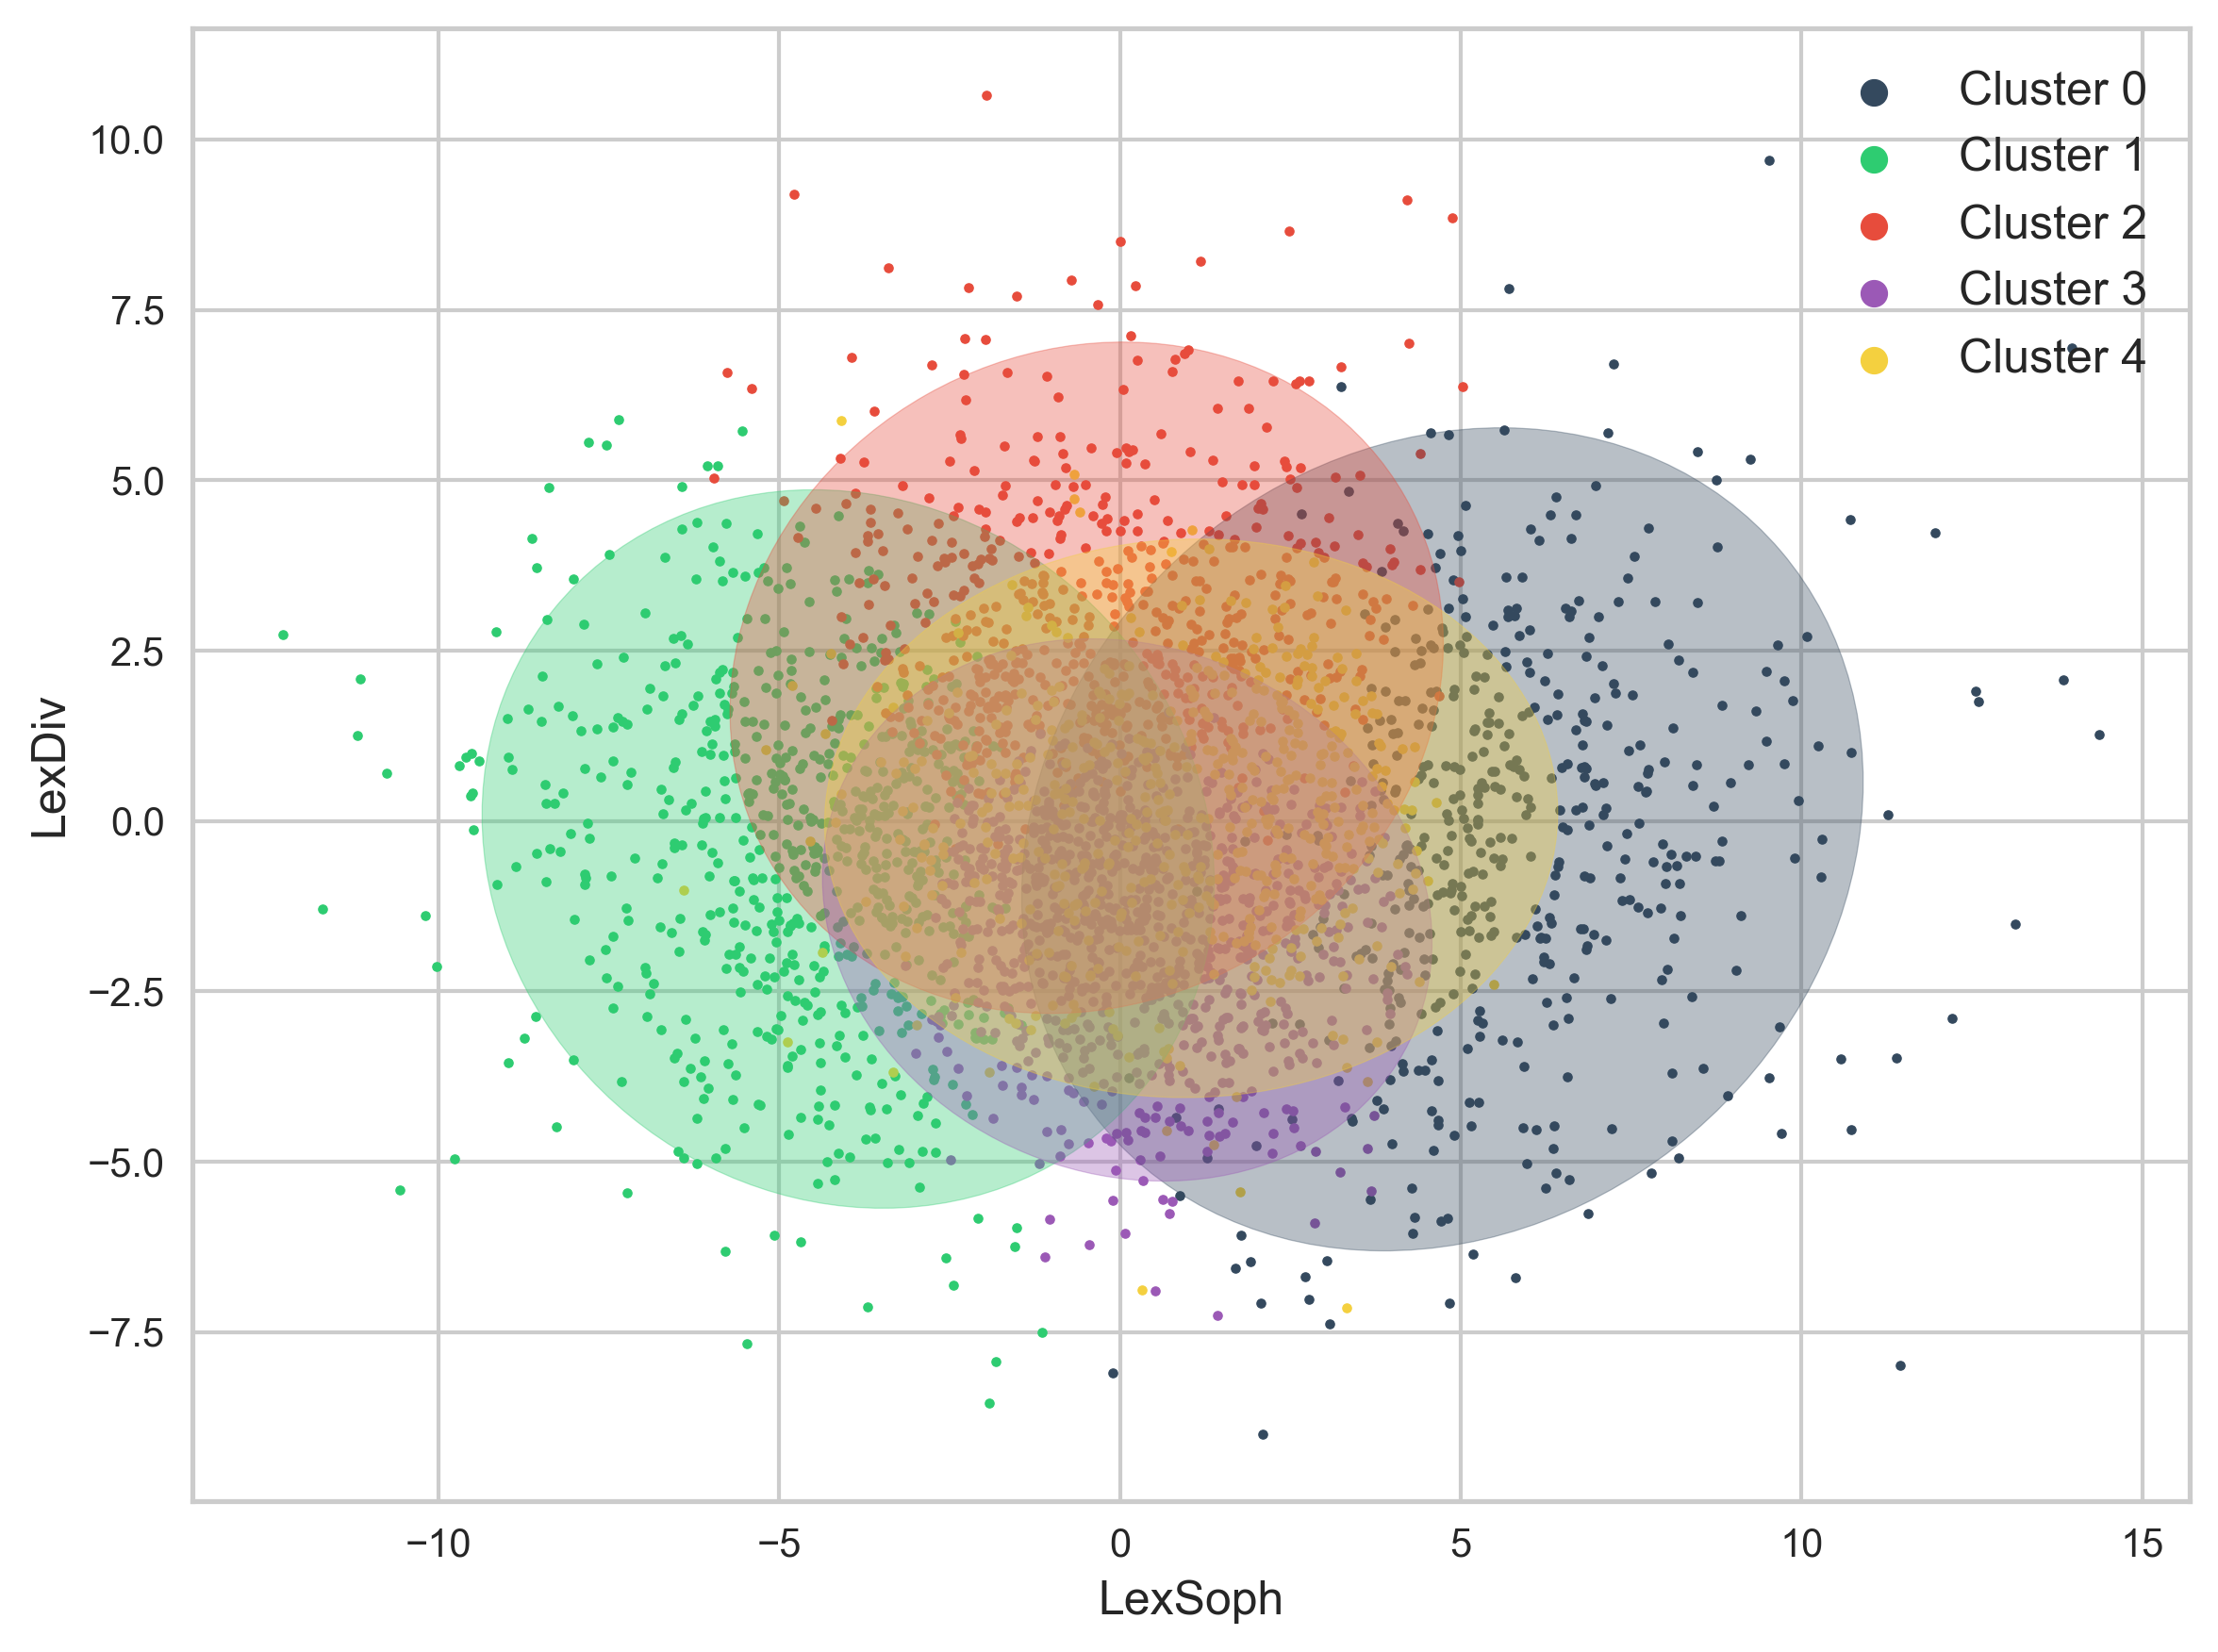

In [7]:
# Dynamically assign colors for each cluster (cycle through palette if needed)
base_colors = PALETTES["flatui"]
ccode_cl = [base_colors[i % len(base_colors)] for i in range(num_clusters)]

## Plot the resulting Gaussian clusters and covariance ellipses in PC1-PC2 space
# Prepare 2D data for plotting (first two PCs)
X_plot = LC_data_trans[:, :2]
Y_plot = labels

# Create a new figure and axes
fig, ax = pyplot.subplots(figsize=(8, 6), dpi=300)

# Loop through each Gaussian component (cluster)
for i, (mean, covar, color) in enumerate(zip(model.means_, model.covariances_, ccode_cl)):

    # Extract the covariance matrix for the first two PCs
    cov_2d = covar[:2, :2]

    # Eigen-decomposition of the 2D covariance matrix
    # v: eigenvalues (variance along principal directions)
    # w: eigenvectors (orientation of the ellipse axes)
    v, w = linalg.eigh(cov_2d)

    # Skip this cluster if no points were assigned to it
    if not numpy.any(Y_plot == i):
        continue

    # Plot the indiviual data points for the current cluster
    pyplot.scatter(X_plot[Y_plot == i, 0], X_plot[Y_plot == i, 1], s=5, color=color, label="Cluster {}".format(i))

    # Compute the orientation (rotation angle) of the covariance ellipse
    # The angle is determined by the first eigenvector of the covariance matrix
    angle = numpy.arctan2(w[0][1], w[0][0])  # orientation in radians
    angle = 180.0 * angle / numpy.pi  # convert to degrees

    # Scale the eigenvalues to get the width and height of the ellipse
    v = 3.0 * numpy.sqrt(2.0) * numpy.sqrt(v)  # approximates a coverage similar to 3 standard deviations along each principal axis (i.e., most of the cluster mass)

    # Create an ellipse patch representing the covariance structure
    ellpise = Ellipse(mean[:2],         # centered at the cluster mean
                      v[0],             # width
                      v[1],             # height
                      180.0 + angle,    # rotation angle in degrees
                      color=color)
    ellpise.set_clip_box(ax.bbox)
    ellpise.set_zorder(3)   # Set drawing order so ellipses above points
    ellpise.set_alpha(0.35)
    ax.add_artist(ellpise)

# Set labels and legend
pyplot.xlabel("LexSoph", fontsize=12)
pyplot.ylabel("LexDiv", fontsize=12)
pyplot.legend(fontsize=12, markerscale=3, loc ="upper right")
pyplot.tight_layout()

# Save the figure as a PDF
pyplot.savefig("clusters_covariance_ellipses.pdf", format="pdf", bbox_inches="tight")
pyplot.show()

In [ ]:
# Silhouette score for the final model
sil_av = metrics.silhouette_score(LC_data_trans, labels, 
                                  metric="mahalanobis")
# Calculate Silhoutte Score for each sample
sil_scrs = metrics.silhouette_samples(LC_data_trans, labels, 
                                      metric="mahalanobis")

# Group the silhouette scores by cluster label in ascending order
n = len(sil_scrs)
ordered = sorted(zip(sil_scrs, labels), key=itemgetter(1), 
                 reverse=False)
ordered_sil = [dat for dat, lab in ordered]
ordered_labels = [lab for dat, lab in ordered]

# Sort the silhouette scores within each cluster in ascending order
sil_cls = []
for k in range(num_clusters):
    cluster_scores = []
    for i in range(len(ordered_sil)):
        if ordered_labels[i] == k:
            cluster_scores.append(ordered_sil[i])
    sil_cls.append(sorted(cluster_scores, reverse=False))

Overall silhouette score for the final model:  0.17453476438035778


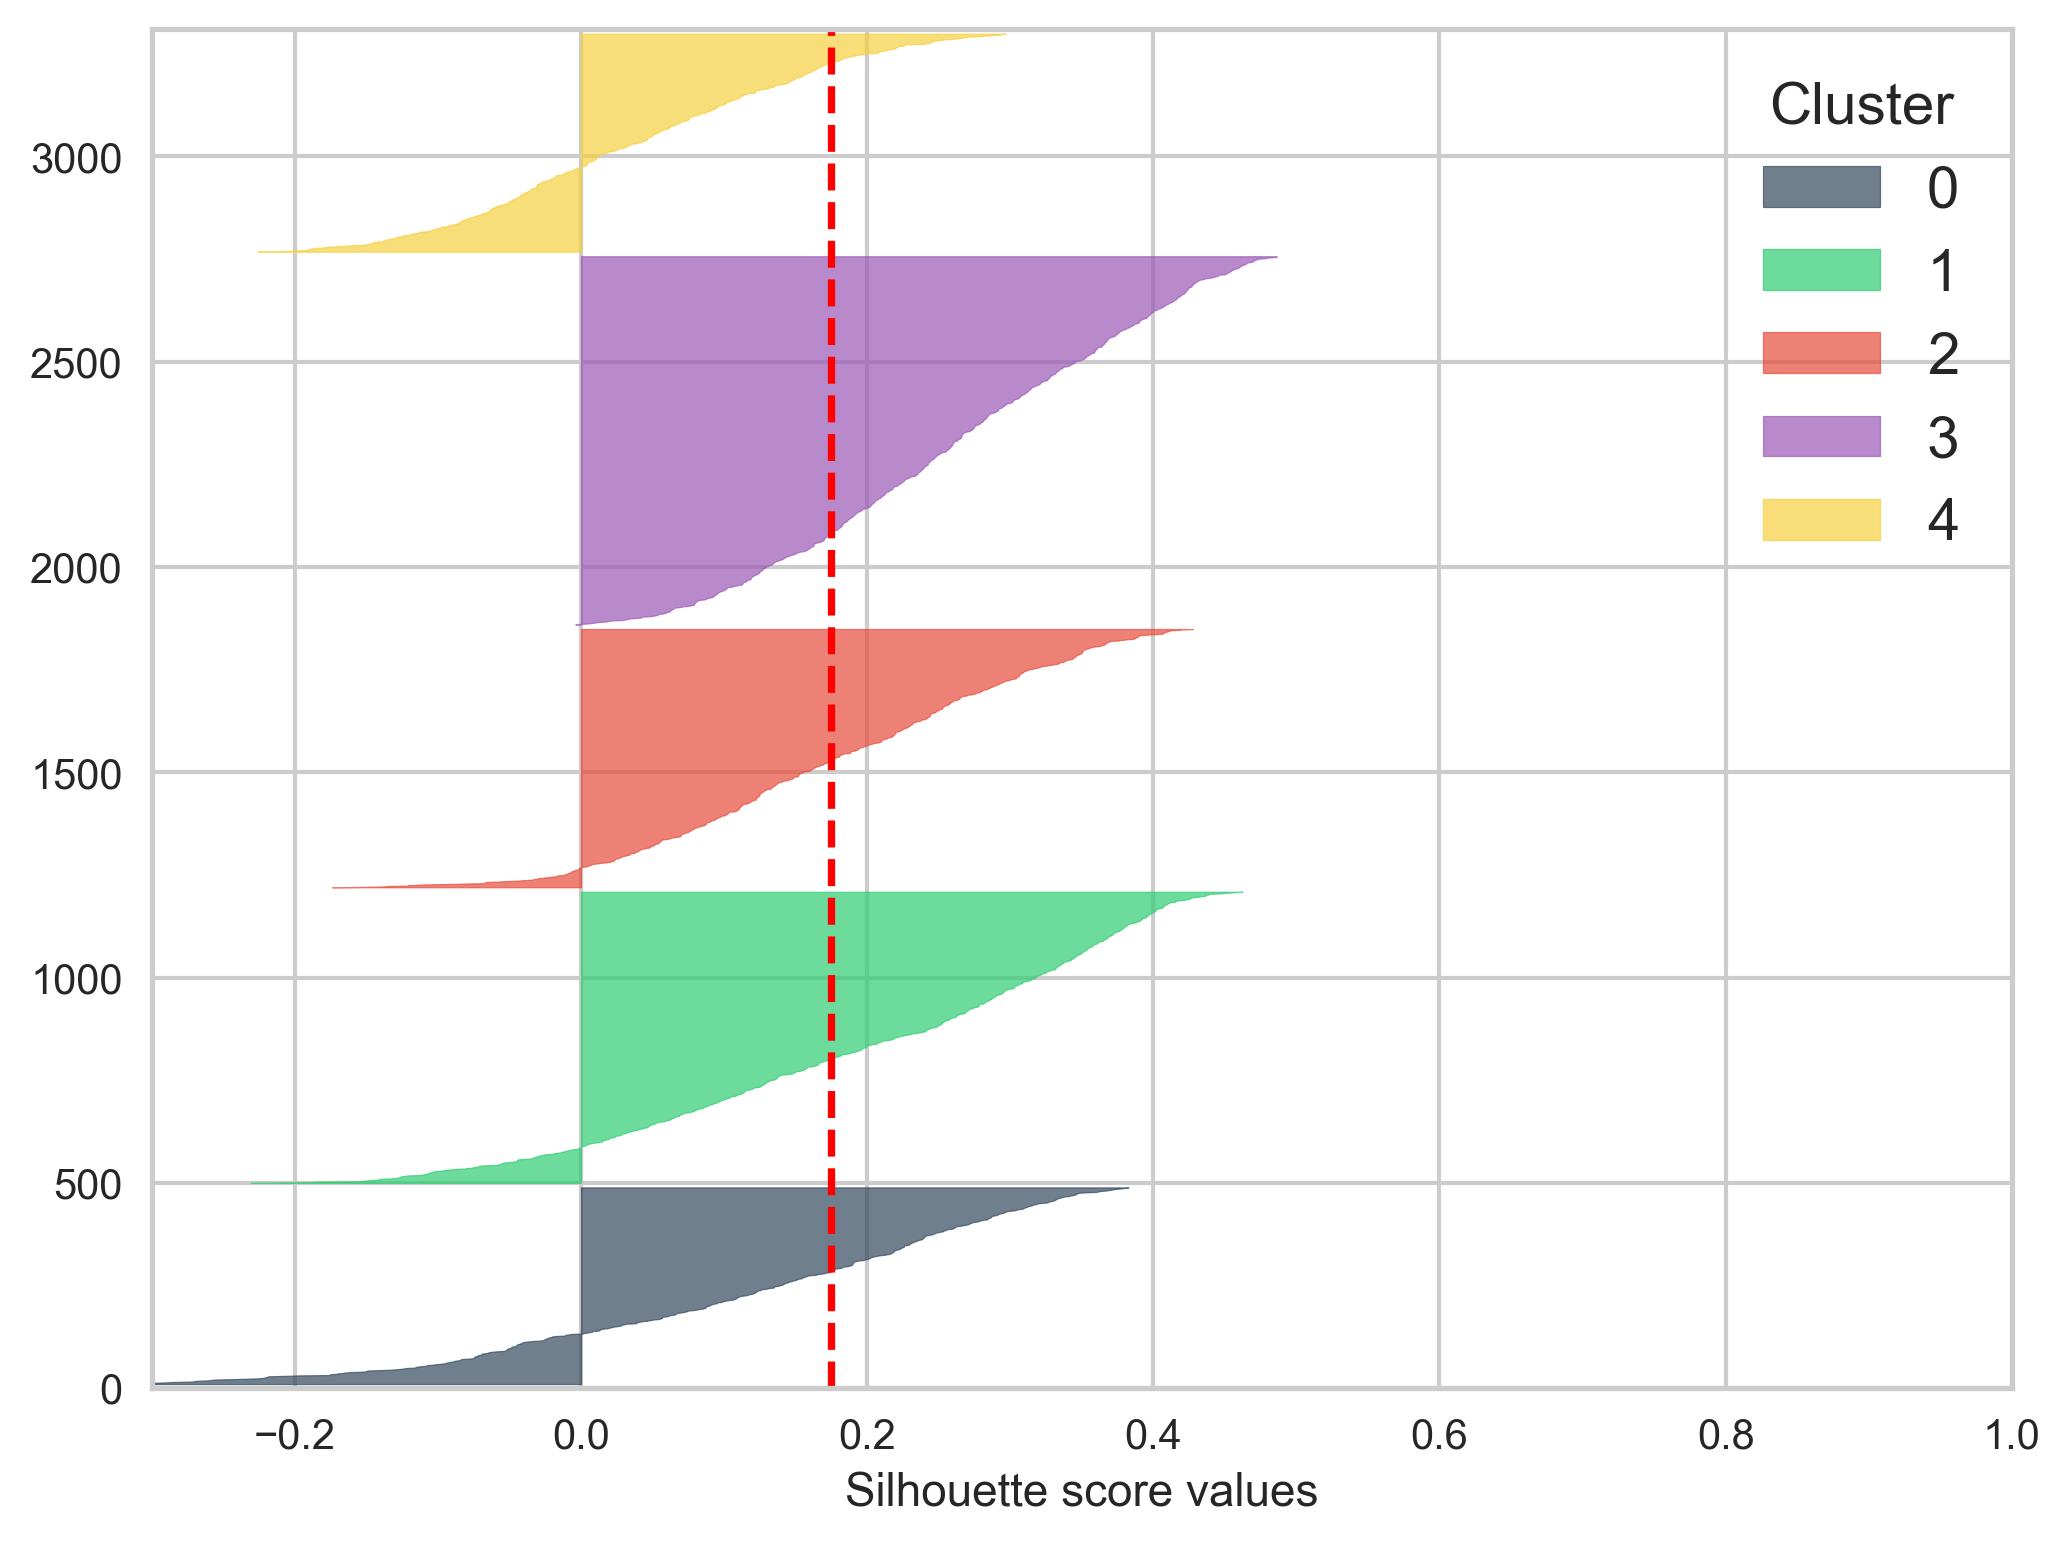

In [9]:
## Plot the silhouette scores
pyplot.figure(figsize=(8,6), dpi=300)

# Set and adjust axes to fit all data points
ax = pyplot.gca()
ax.set_xlim([-0.3, 1])
ax.set_ylim([0, n + (num_clusters + 1) * 10])

# Initial vertical offset for the first cluster
y_lower = 10
# Loop through each cluster to plot silhouette values
for i in range(num_clusters):
    ith_cluster_silhouette_values = sil_cls[i]
    size_cluster_i = len(ith_cluster_silhouette_values)
    y_upper = y_lower + size_cluster_i
    # Plot individual silhouette scores as horizontal bars for the current cluster
    color = ccode_cl[i]
    ax.fill_betweenx(numpy.arange(y_lower, y_upper), # y range
                     0, # starting x value
                     ith_cluster_silhouette_values, 
                     facecolor=color, 
                     edgecolor=color, 
                     alpha=0.7)
    # Upandasate the vertical offset for the next cluster
    y_lower = y_upper + 10

# Set x-axis labels
ax.set_xlabel("Silhouette score values")
# Add vertical line to show the average silhouette score
print("Overall silhouette score for the final model: ", sil_av)
ax.axvline(x=sil_av, color="red", linestyle="--")
# Add lengend
ax.legend([str(i) for i in range(num_clusters)], loc="upper right",
          fontsize=14, title="Cluster", title_fontsize=14)
# Save the figure as a PDF
pyplot.savefig("silhouette_plot.pdf", format="pdf", bbox_inches="tight")
pyplot.show()

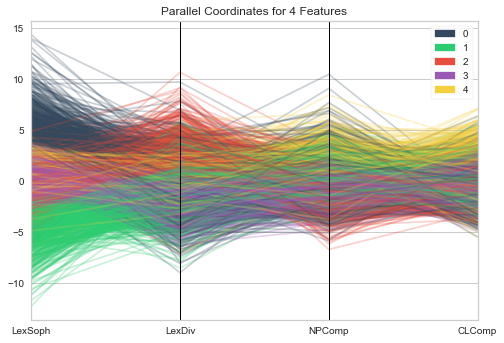

<AxesSubplot:title={'center':'Parallel Coordinates for 4 Features'}>

In [10]:
## Parallel coordinates
pc = ParallelCoordinates(classes=sorted(numpy.unique(labels)), 
              features=["LexSoph", "LexDiv", "NPComp", "CLComp"], 
              colors=ccode_cl, shuffle=True, 
              random_state=3, 
              dpi=300)
pc.fit(LC_data_trans, labels)
pc.finalize()

# Save the figure as a PDF
pyplot.savefig("parallel_coordinates.pdf", format="pdf", bbox_inches="tight")
pc.show()

In [11]:
# Create a contingency table
contingency_table = pandas.crosstab(data["Score"], data["Cluster"])
print(contingency_table)

Cluster    0    1    2    3    4
Score                           
2        174  477  220  431  256
3        227  211  355  419  224
4         79   22   55   48   52


In [12]:
# Perform Chi-squared test
chi2, p, df, _ = chi2_contingency(contingency_table)
print("Chi-squared test statistic:", round(chi2, 2))  # round to 2 decimals
print("p-value:", p)
print("Degrees of freedom:", df)

Chi-squared test statistic: 224.12
p-value: 5.175510565470877e-44
Degrees of freedom: 8


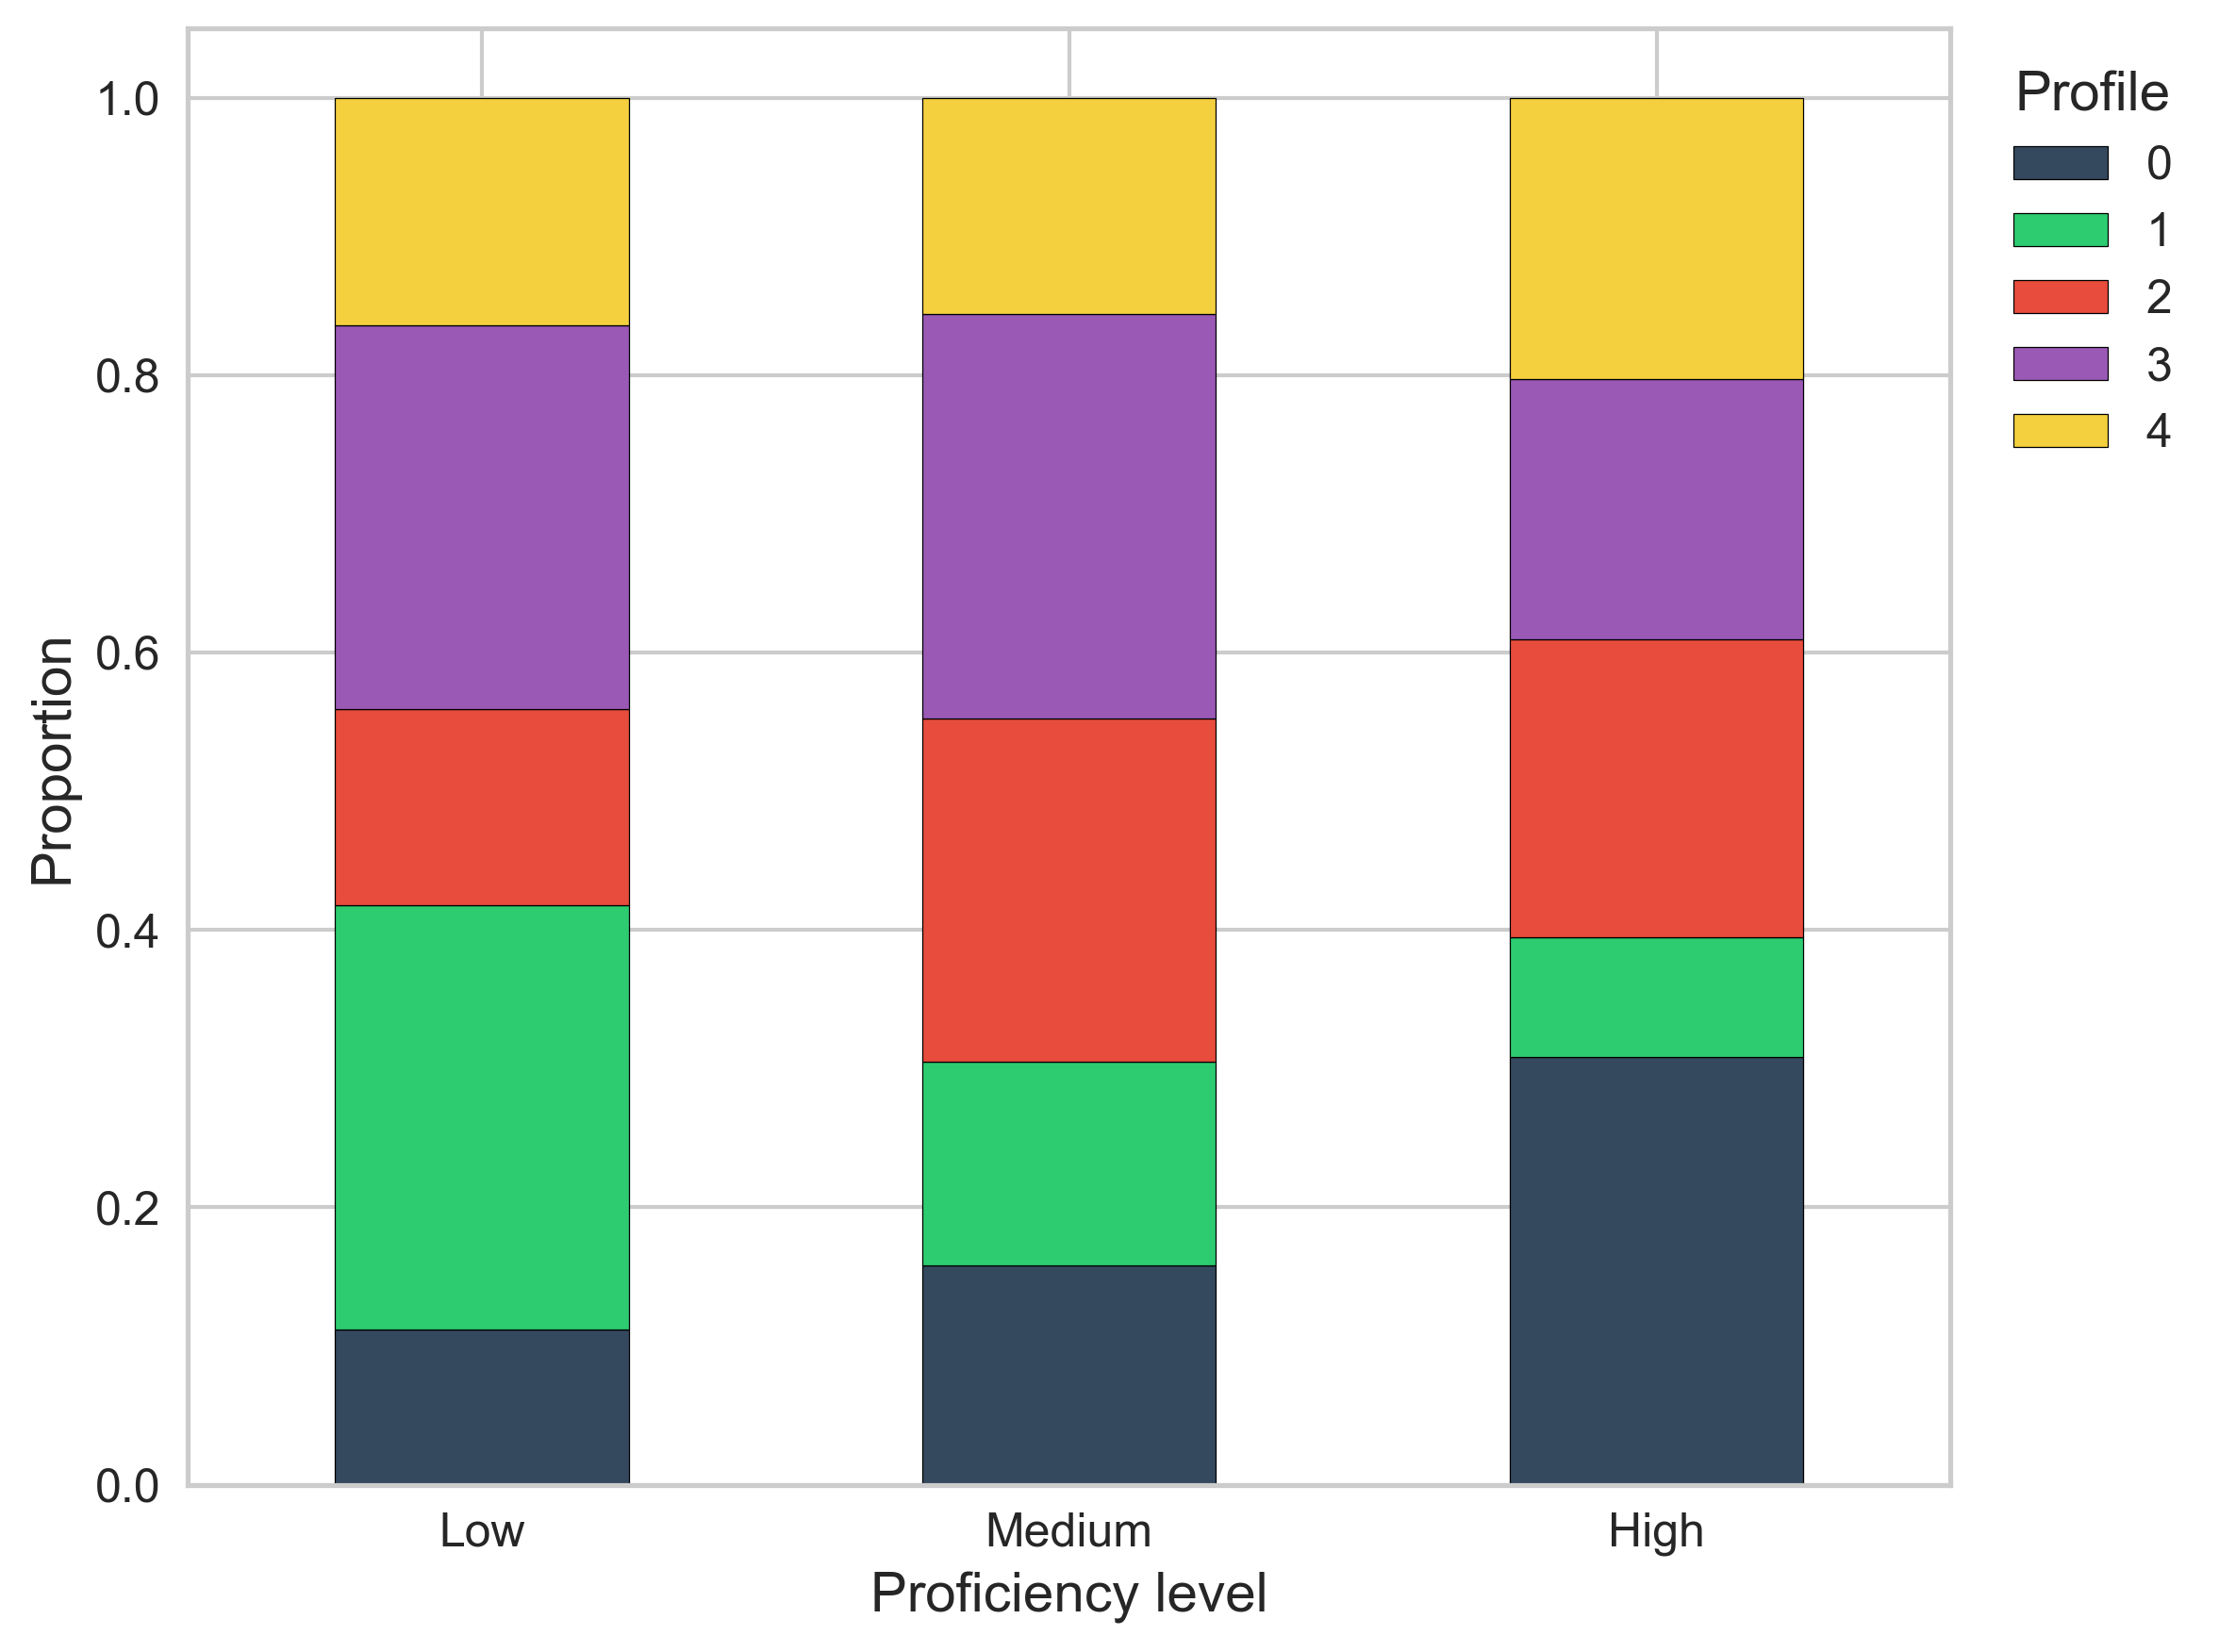

In [13]:
# Plot a stacked bar chart of profile by proficiency level using proportion
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
fig, ax = pyplot.subplots(figsize=(8, 6), dpi=300)
proportions.plot(kind="bar", stacked=True, color=ccode_cl, 
                        figsize=(8, 6), edgecolor="black", ax=ax)  
ax.set_xlabel("Proficiency level", fontsize=14)
ax.set_ylabel("Proportion", fontsize=14)
ax.set_xticklabels(["Low", "Medium", "High"], fontsize=12, rotation=0)
ax.tick_params(axis="y", labelsize=12)
ax.legend(title="Profile", loc="upper right", bbox_to_anchor=(1.15, 1),
    fontsize=12, title_fontsize=14)
pyplot.tight_layout()
# Save the figure as a PDF
pyplot.savefig("distribution_bar_chart.pdf", format="pdf", bbox_inches="tight")
pyplot.show()